# COVID Analysis

Examines a COVID dataset...  

---

In [1]:
%%file bigdata.py

from mrjob.job import MRJob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

class map_read(MRJob):
    def mapper(self, _, line):
        line = line.split(",")
        if line[2] == "1":
            yield "Female", (line[3], line[4], line[6], line[9], line[10], 
                             line[11], line[12], line[13], line[14],
                             line[15], line[16], line[17], line[18])
        else:
            yield "Male", (line[3], line[4], line[6], line[9], line[10], 
                           line[11], line[12], line[13], line[14],
                           line[15], line[16], line[17], line[18])
            
    def reducer(self, key, values):
        if key == "Female":
            fdeaths = 0
            fcount = 0
            fhospitalized = 0
            fpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            fcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                fcount += 1
                if x[0] == "1":
                    fhospitalized += 1
                if x[1] != "9999-99-99":
                    fdeaths += 1
                if "1" in x[2:-1]:
                    fpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        fcondition[i] += 1
                        
            yield "Female Stats", {"count": fcount, "deaths": fdeaths, 
                                   "hospitalized": fhospitalized,
                                   "pre-existing condition": fpreexisting}
            yield "Death Stats", {
            "Female": {
            "deaths": fdeaths,
            "hospitalized": fhospitalized,
            "conditions": {
                "pneumonia": fcondition[0],
                "diabetes": fcondition[1],
                "copd": fcondition[2],
                "asthma": fcondition[3],
                "immunosuppressed": fcondition[4],
                "hypertension": fcondition[5],
                "other": fcondition[6],
                "cardiovascular": fcondition[7],
                "obesity": fcondition[8],
                "renal": fcondition[9],
                "tobacco": fcondition[10]      
                }
            }}
        
        else:
            mdeaths = 0
            mcount = 0
            mhospitalized = 0
            mpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            mcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                mcount += 1
                if x[0] == "1":
                    mhospitalized += 1
                if x[1] != "9999-99-99":
                    mdeaths += 1
                if "1" in x[2:-1]:
                    mpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        mcondition[i] += 1
            yield "Male Stats", {"count": mcount, "deaths": mdeaths,
                                 "hospitalized": mhospitalized,
                                 "pre-existing condition": mpreexisting}
            yield "Death Stats", {
            "Male": {
            "deaths": mdeaths,
            "hospitalized": mhospitalized,
            "conditions": {
                "pneumonia": mcondition[0],
                "diabetes": mcondition[1],
                "copd": mcondition[2],
                "asthma": mcondition[3],
                "immunosuppressed": mcondition[4],
                "hypertension": mcondition[5],
                "other": mcondition[6],
                "cardiovascular": mcondition[7],
                "obesity": mcondition[8],
                "renal": mcondition[9],
                "tobacco": mcondition[10]      
                }
            }}
        
if __name__ =='__main__':
    map_read.run()

Overwriting bigdata.py


In [2]:
!python bigdata.py "Covid Data.csv"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221213.060307.279235
Running step 1 of 1...
job output is in C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221213.060307.279235\output
Streaming final output from C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221213.060307.279235\output...
Removing temp directory C:\Users\rtwyc\AppData\Local\Temp\bigdata.rtwyc.20221213.060307.279235...


"Female Stats"	{"count":525064,"deaths":27402,"hospitalized":443338,"pre-existing condition":208078}
"Death Stats"	{"Female":{"deaths":27402,"hospitalized":443338,"conditions":{"pneumonia":18980,"diabetes":11545,"copd":1772,"asthma":788,"immunosuppressed":1159,"hypertension":13429,"other":1955,"cardiovascular":1725,"obesity":7119,"renal":2354,"tobacco":1120}}}
"Male Stats"	{"count":523512,"deaths":49541,"hospitalized":405206,"pre-existing condition":219872}
"Death Stats"	{"Male":{"deaths":49541,"hospitalized":405206,"conditions":{"pneumonia":34943,"diabetes":16720,"copd":2249,"asthma":692,"immunosuppressed":1459,"hypertension":18632,"other":2591,"cardiovascular":2710,"obesity":10175,"renal":3353,"tobacco":5476}}}


# Pre-existing Conditions and COVID19

Later, we will attempt to create a classifier that will predict whether a patient will be able to survive a COVID19 infection through logistic regression.

But first, let us task ourselves with analyzing our datasets and see how pre-existing conditions affect a patient's chances of survival. For this task, we will not be taking into account the type of care they received during their infection.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [4]:
# Extract csv information into dataframe
df = pd.read_csv('Covid Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# Cleaning Dataset

Looking at df.info(), we can see that there are no null values, which is good. This means we do not have to worry about removing missing values in our data. However, according to the descriptions of the columns, a value of "97" or "99" indicates unknown, which we will take care of later.

Since our analyzation only focuses on the patient's pre-existing conditions, we will remove all columns that involve how they were cared for during their contraction of COVID19, which includes columns: CLASIFFICATION_FINAL, PATIENT_TYPE, USMER, MEDICAL_UNIT, INTUBED, ICU

In [5]:
df.drop('CLASIFFICATION_FINAL', axis = 1, inplace=True)
df.drop('PATIENT_TYPE', axis = 1, inplace=True)
df.drop('USMER', axis = 1, inplace=True)
df.drop('MEDICAL_UNIT', axis = 1, inplace=True)
df.drop('INTUBED', axis = 1, inplace=True)
df.drop('ICU', axis = 1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   SEX             1048575 non-null  int64 
 1   DATE_DIED       1048575 non-null  object
 2   PNEUMONIA       1048575 non-null  int64 
 3   AGE             1048575 non-null  int64 
 4   PREGNANT        1048575 non-null  int64 
 5   DIABETES        1048575 non-null  int64 
 6   COPD            1048575 non-null  int64 
 7   ASTHMA          1048575 non-null  int64 
 8   INMSUPR         1048575 non-null  int64 
 9   HIPERTENSION    1048575 non-null  int64 
 10  OTHER_DISEASE   1048575 non-null  int64 
 11  CARDIOVASCULAR  1048575 non-null  int64 
 12  OBESITY         1048575 non-null  int64 
 13  RENAL_CHRONIC   1048575 non-null  int64 
 14  TOBACCO         1048575 non-null  int64 
dtypes: int64(14), object(1)
memory usage: 120.0+ MB


Next, because we want to focus on whether the patient passed away or lived, let's take a look at the "DATE_DIED" column.

In [6]:
df

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,03/05/2020,1,65,2,2,2,2,2,1,2,2,2,2,2
1,2,03/06/2020,1,72,97,2,2,2,2,1,2,2,1,1,2
2,2,09/06/2020,2,55,97,1,2,2,2,2,2,2,2,2,2
3,1,12/06/2020,2,53,2,2,2,2,2,2,2,2,2,2,2
4,2,21/06/2020,2,68,97,1,2,2,2,1,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,9999-99-99,2,40,97,2,2,2,2,2,2,2,2,2,2
1048571,2,9999-99-99,2,51,97,2,2,2,2,1,2,2,2,2,2
1048572,2,9999-99-99,2,55,97,2,2,2,2,2,2,2,2,2,2
1048573,2,9999-99-99,2,28,97,2,2,2,2,2,2,2,2,2,2


Here, we can see that if the patient survived, the value for "DATE_DIED" is "9999-99-99." Because our focus is whether the patient lived or not and we do not care about when they passed, we will simply change the "DATE_DIED" value to either 0 for lived and 1 for expired.

Moreover, according to the column descriptions, except for the sex column in which 1 means female and 2 means male, a value of 1 means "yes" and a value of 2 means "no," thus we will replace all 2's with 0's. We also know that "97" or "99" indicates unknown, which we will then replace with -1. Datasets will always have data that are unknown, and we will just have to disregard these data by setting them as -1.

Lastly, we will deal with the age column by categorizing 55 and older as 1 and 54 and younger as 0.
We will also drop duplicate data if any.

In [7]:
sum(df.duplicated())

951266

In [8]:
df.drop_duplicates(inplace = True)
df.loc[df['DATE_DIED'] != '9999-99-99', 'DATE_DIED'] = 1
df.loc[df['DATE_DIED'] == '9999-99-99', 'DATE_DIED'] = 0
df["DATE_DIED"] = pd.to_numeric(df["DATE_DIED"])

df = df.replace(2, 0)
df = df.replace(97, -1)
df = df.replace(99, -1)
df = df.replace(98, -1)

df["AGE"] = np.where(df["AGE"] < 55, 0, 1)
df

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,-1,0,0,0,0,1,0,0,1,1,0
2,0,1,0,1,-1,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,-1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048371,1,0,0,1,0,1,0,0,0,1,0,0,1,1,1
1048414,0,0,0,1,-1,0,0,0,1,1,0,0,0,1,0
1048421,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1
1048527,0,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Printing out df, we can see that our updates were successful.

Next, let's do some visualization to analyze our data by looking at plots to see the differences between patients who survived and patients who expired.

## Visualization

In [9]:
# Preliminary Values
print('Number of cases:', len(df.index))
print('Number of cases alive:', sum(df['DATE_DIED']==0))
print('Number of cases dead:', sum(df['DATE_DIED']==1))

Number of cases: 97309
Number of cases alive: 33910
Number of cases dead: 63399


### Histogram of entire dataset

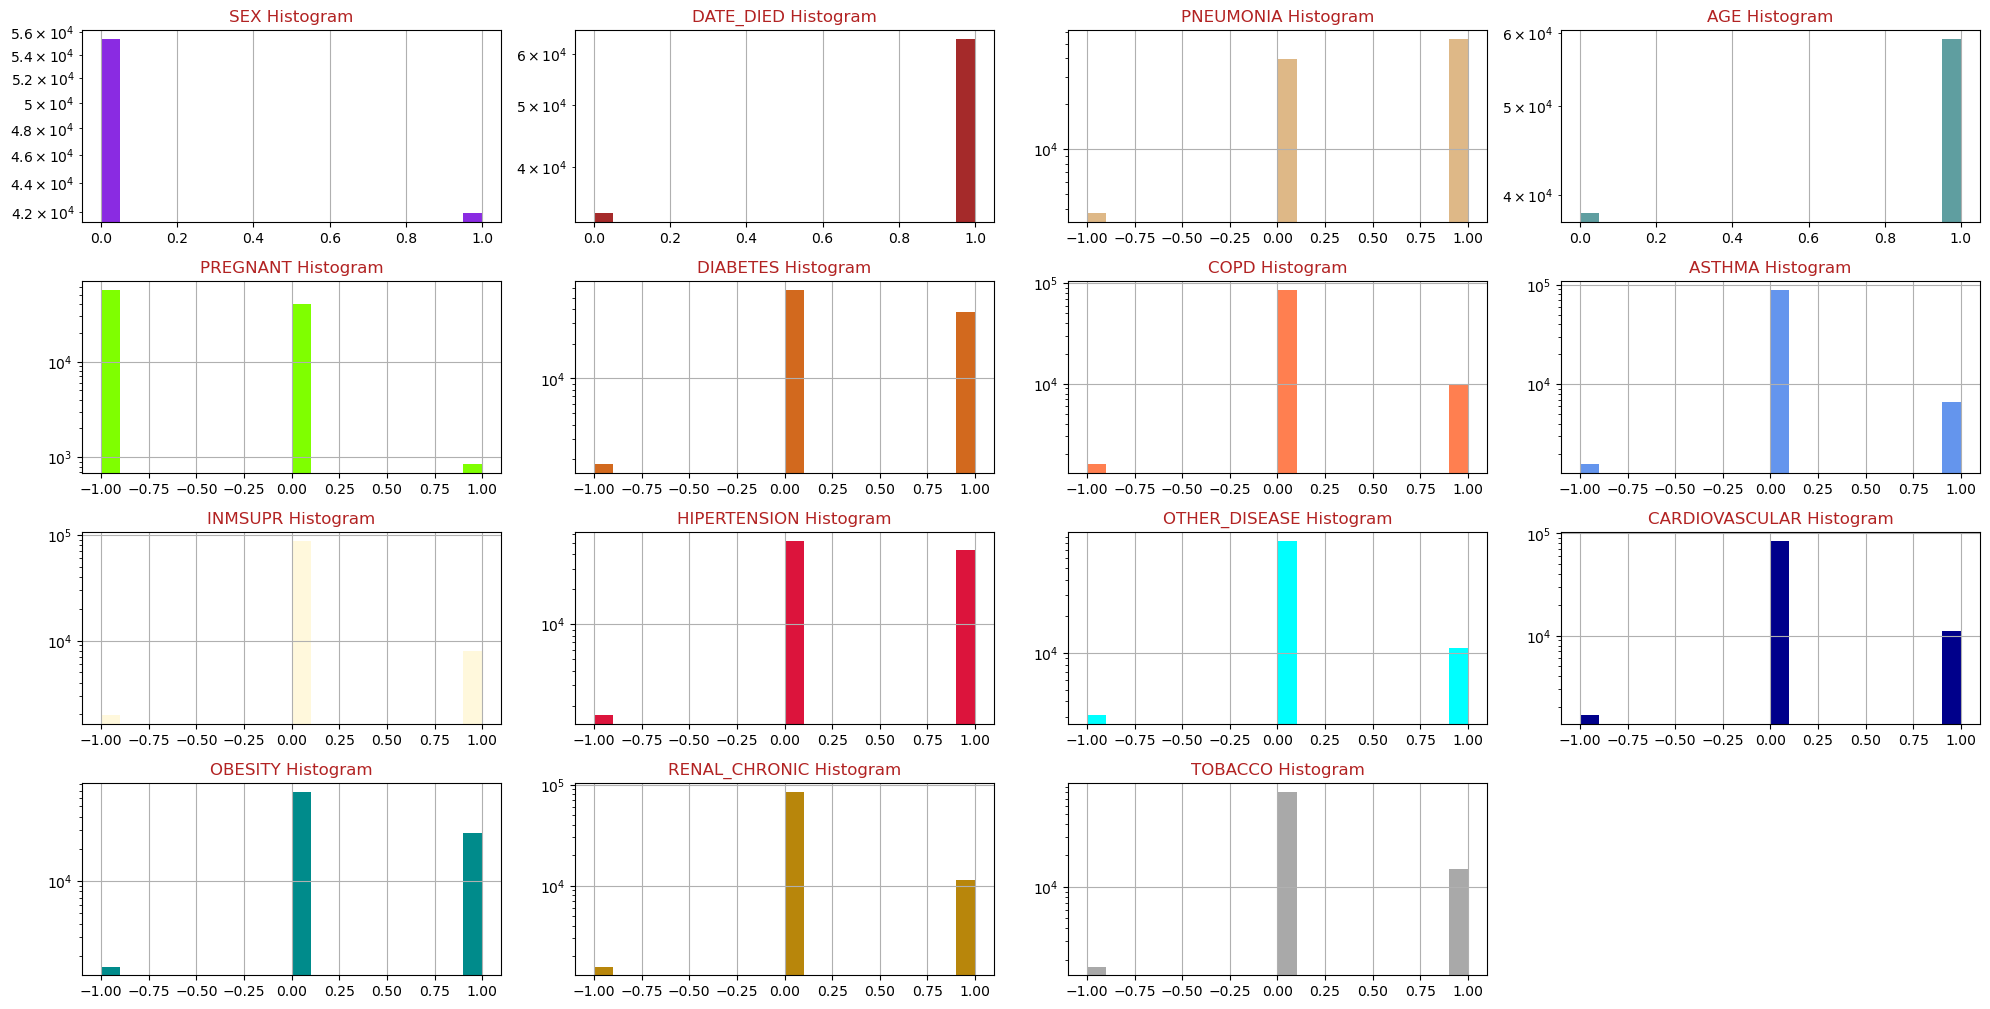

In [10]:
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

### Histogram of 'alive' cases

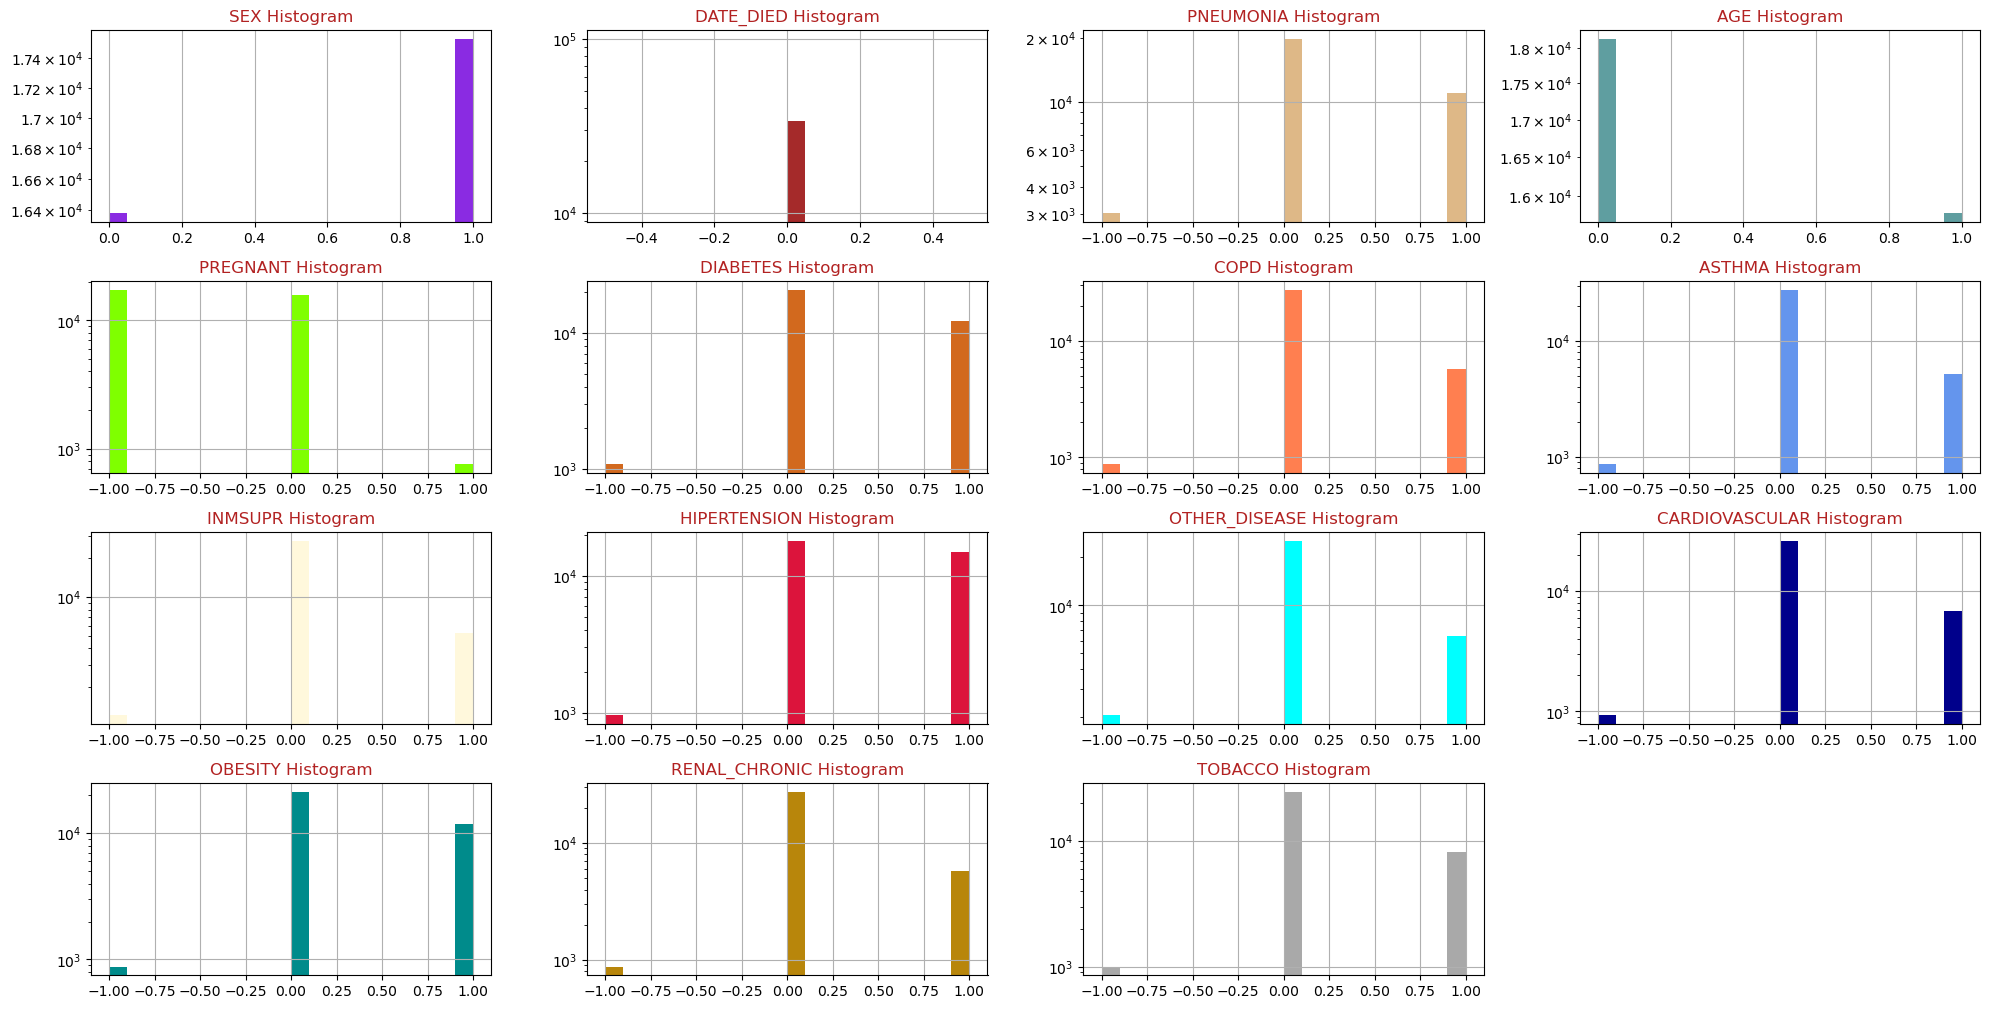

In [11]:
df_alive = df.loc[df['DATE_DIED']==0]

colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_alive.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_alive[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [12]:
df_alive.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0
8,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Histogram of 'dead' cases

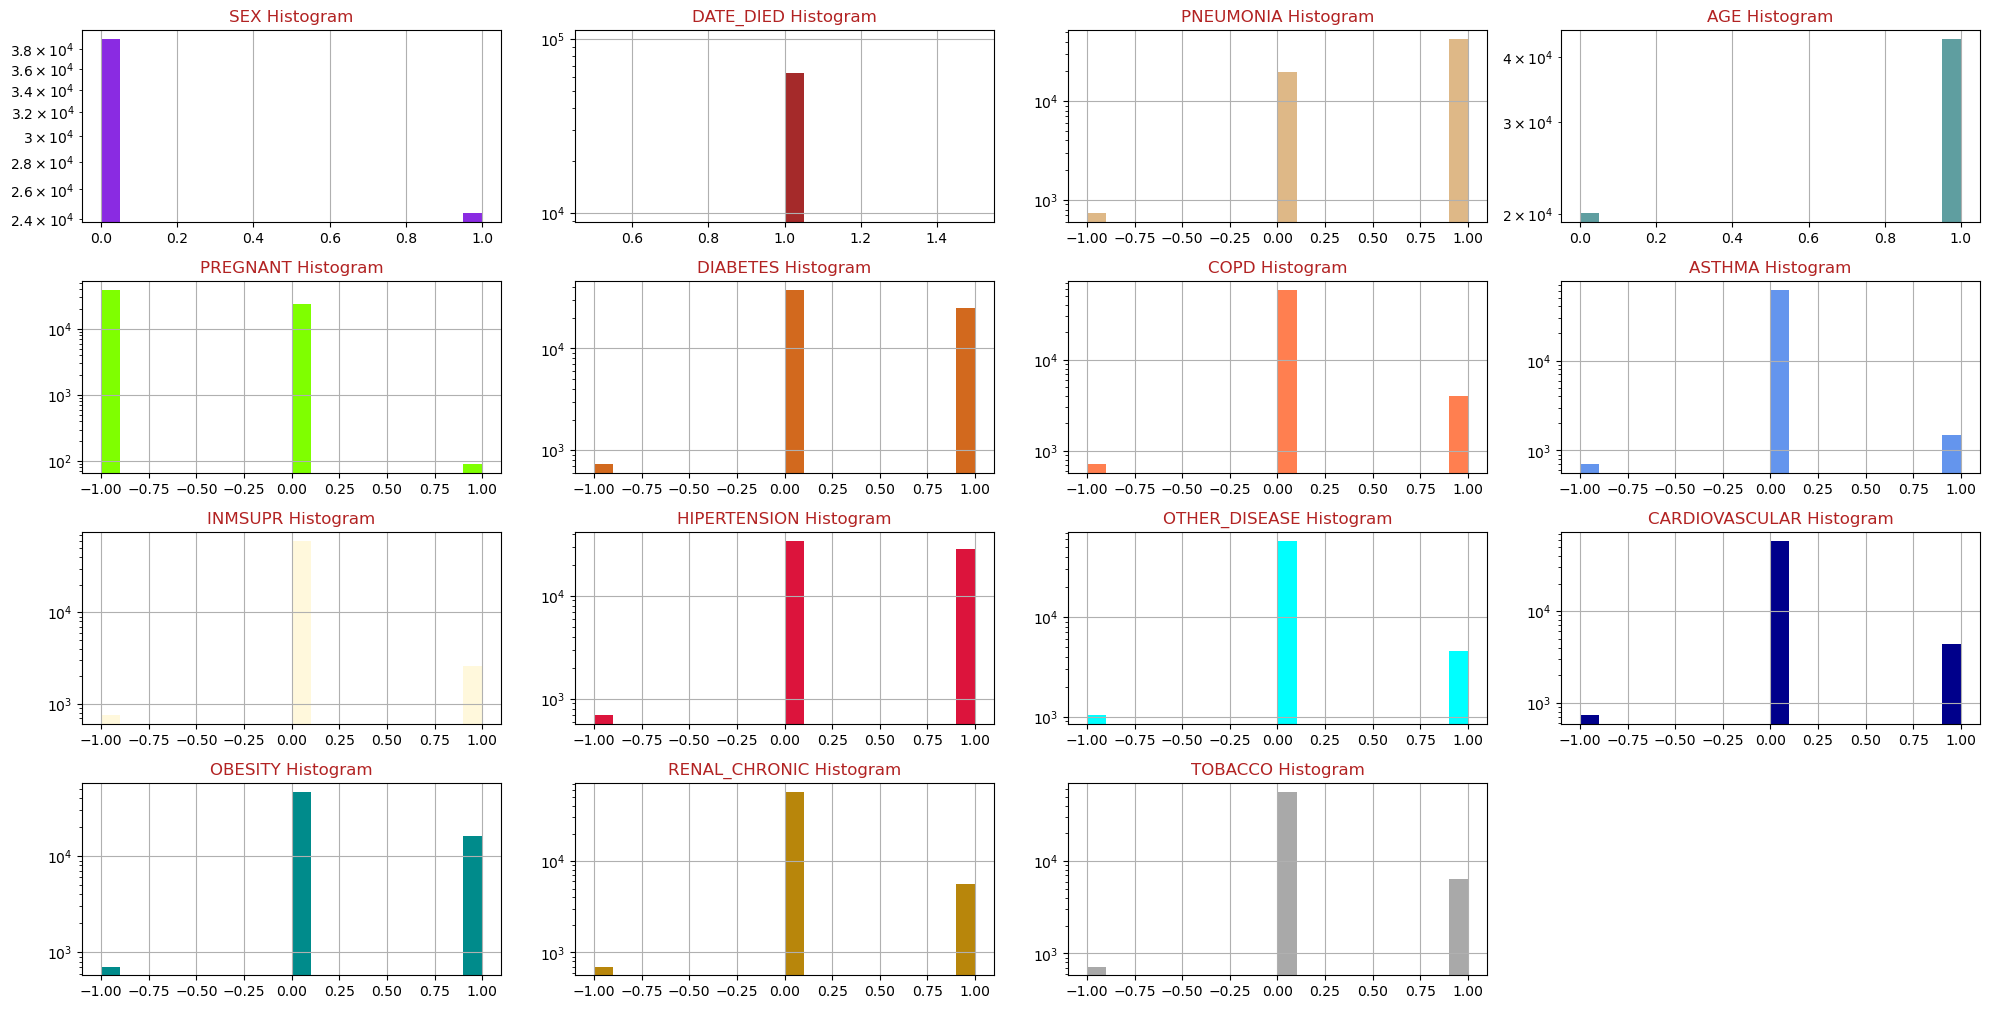

In [13]:
df_expired = df.loc[df['DATE_DIED']==1]

colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_expired.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_expired[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [14]:
df_expired.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,-1,0,0,0,0,1,0,0,1,1,0
2,0,1,0,1,-1,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,-1,1,0,0,0,1,0,0,0,0,0


Next, let's take a look at a heatmap of our data to see if there are any correlations between our columns.

### Heatmap correlation

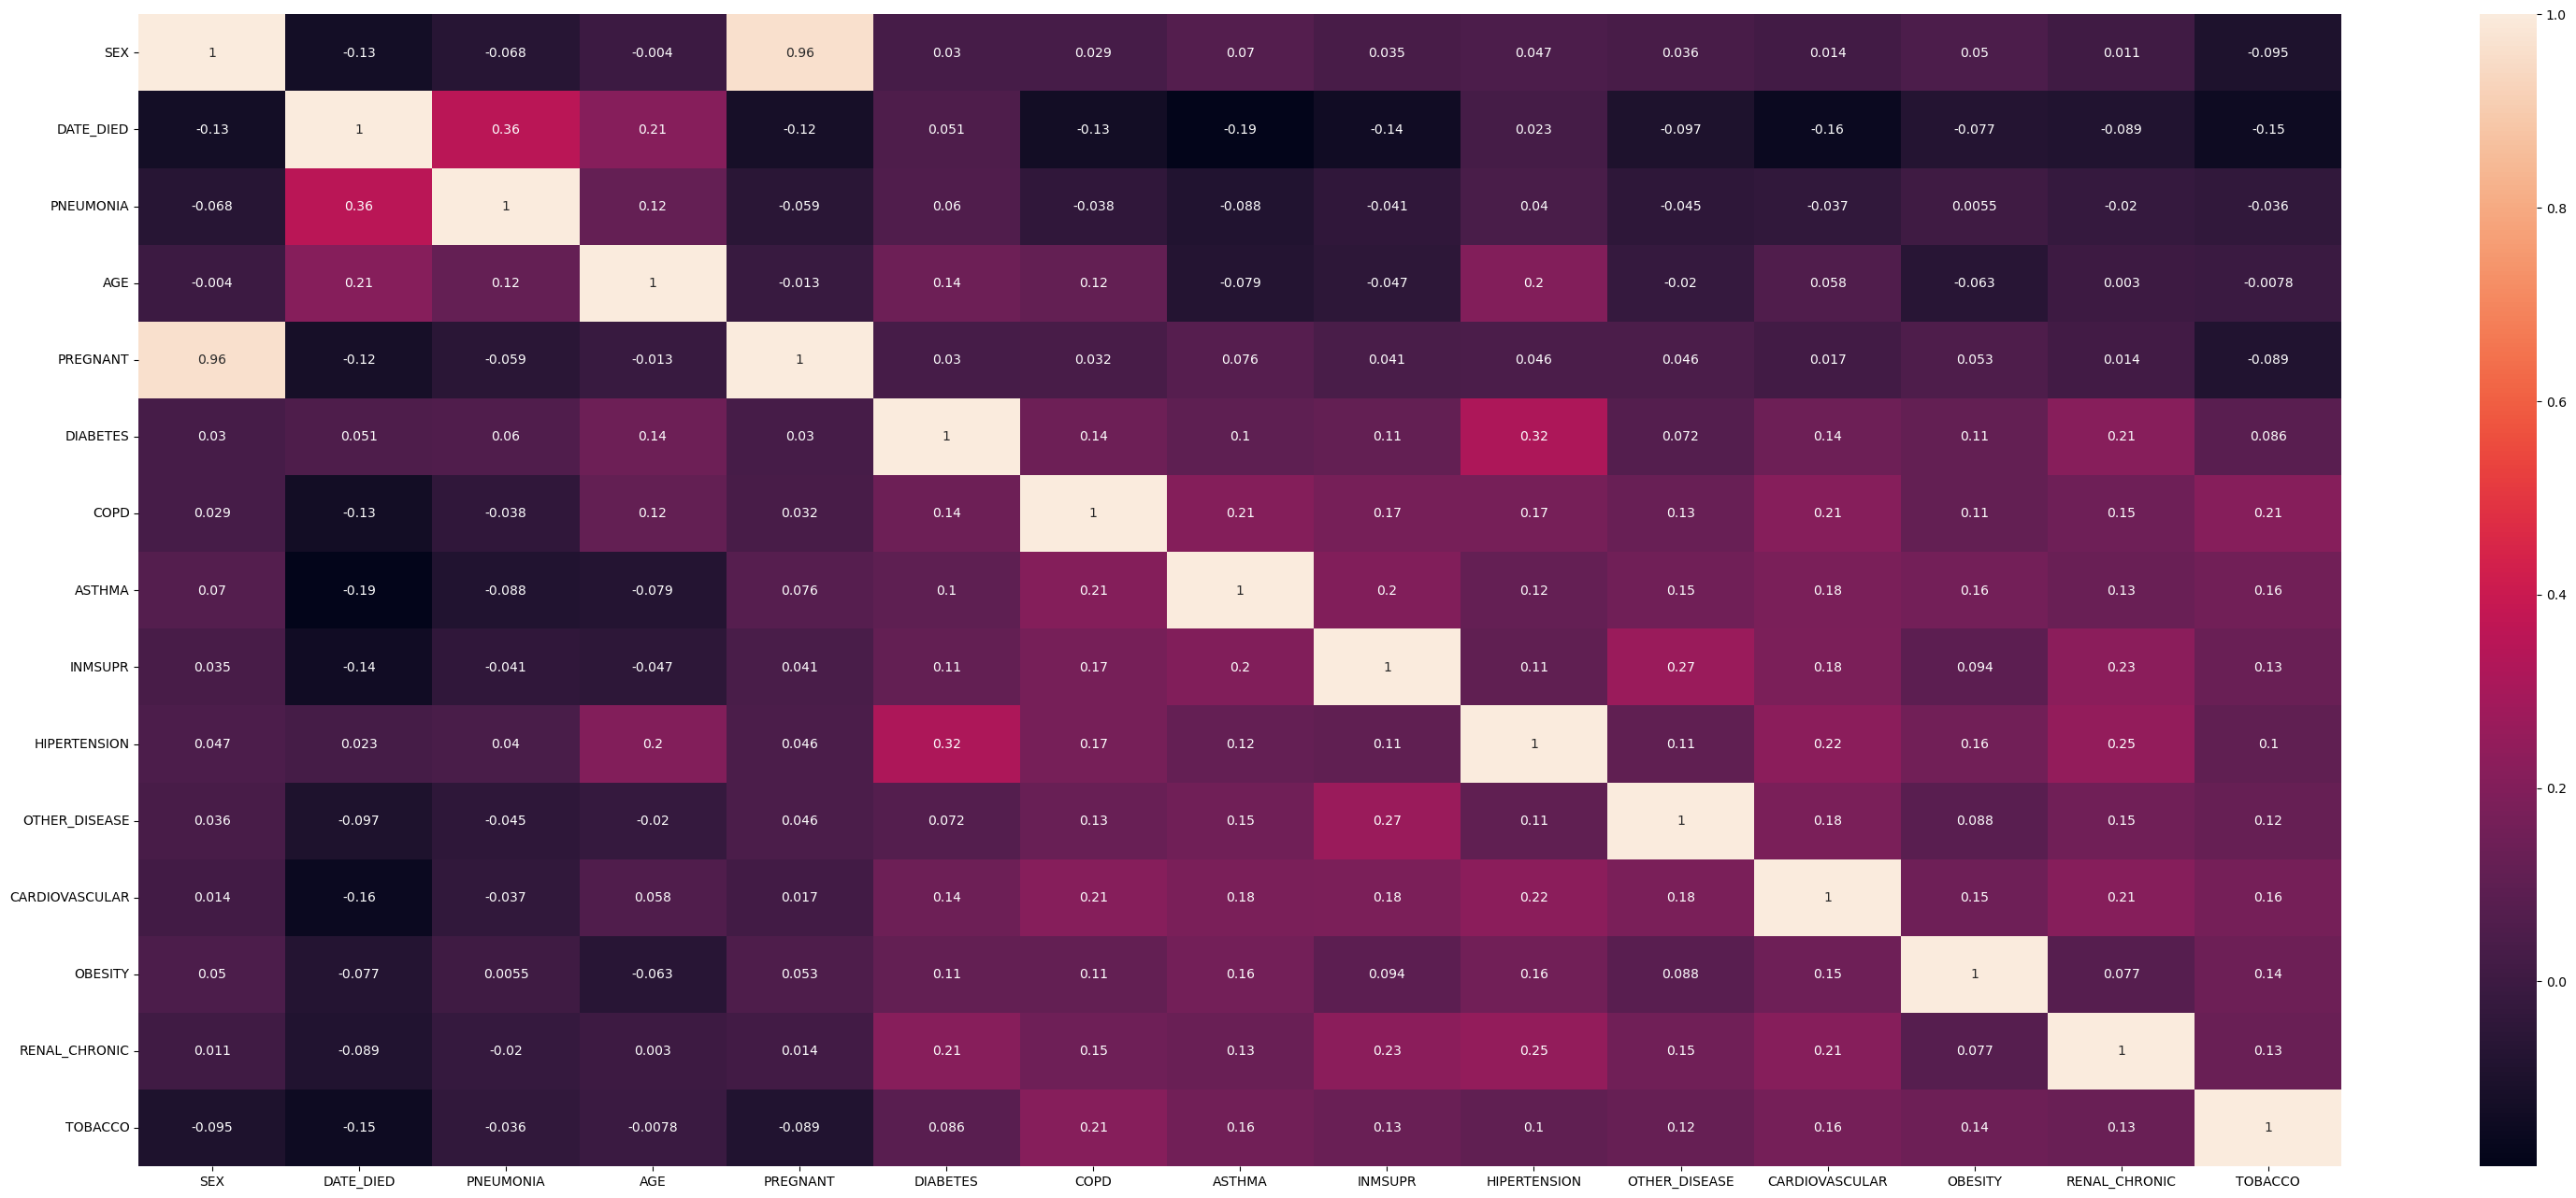

In [15]:
# Heatmap
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Preliminary Analysis

Looking at these plots, we can see a lot of interesting results.
First of all, looking at both the df_alive and df_expired histograms, we can see that most of the nonsurvivors were male (value of 0). We can also see on the df_alive histogram that we have a lot of 0's for our pre-existing conditions, suggesting that the less pre-existing conditions the patient had prior to COVID19 infection, the higher their chances of survival.

Through our df_expired histogram, we can also see that a lot of patients that passed away had pneumonia or was aged at or above 55, which is also evident in our heatmap, showing pneumonia to have the highest and age to have the second highest positive correlation with column DATE_DIED.

## Logistic Regression

After reviewing our datasets, we are finally ready for our regression. Logistic regression was created rather than a linear regression as this model attempts to classify cases between binary values of 'alive' or 'dead'.

---

In [16]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')
df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

In [17]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.iloc[:, df.columns!='ALIVE_DEAD']
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)

In [18]:
# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 93.58%
The accuracy for the test set is 93.65%


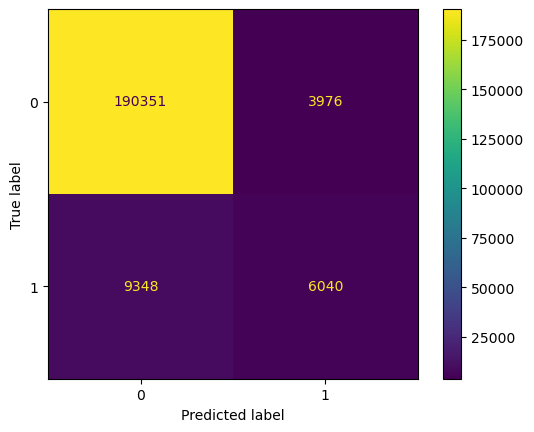

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [20]:
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,ALIVE_DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,1,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,1,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,1,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,0,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,0,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,0,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,0,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [21]:
# Preliminary Values
print('Number of cases:', len(df.index))
print('Number of cases alive:', sum(df['ALIVE_DEAD']==0))
print('Number of cases dead:', sum(df['ALIVE_DEAD']==1))

Number of cases: 1048575
Number of cases alive: 971633
Number of cases dead: 76942


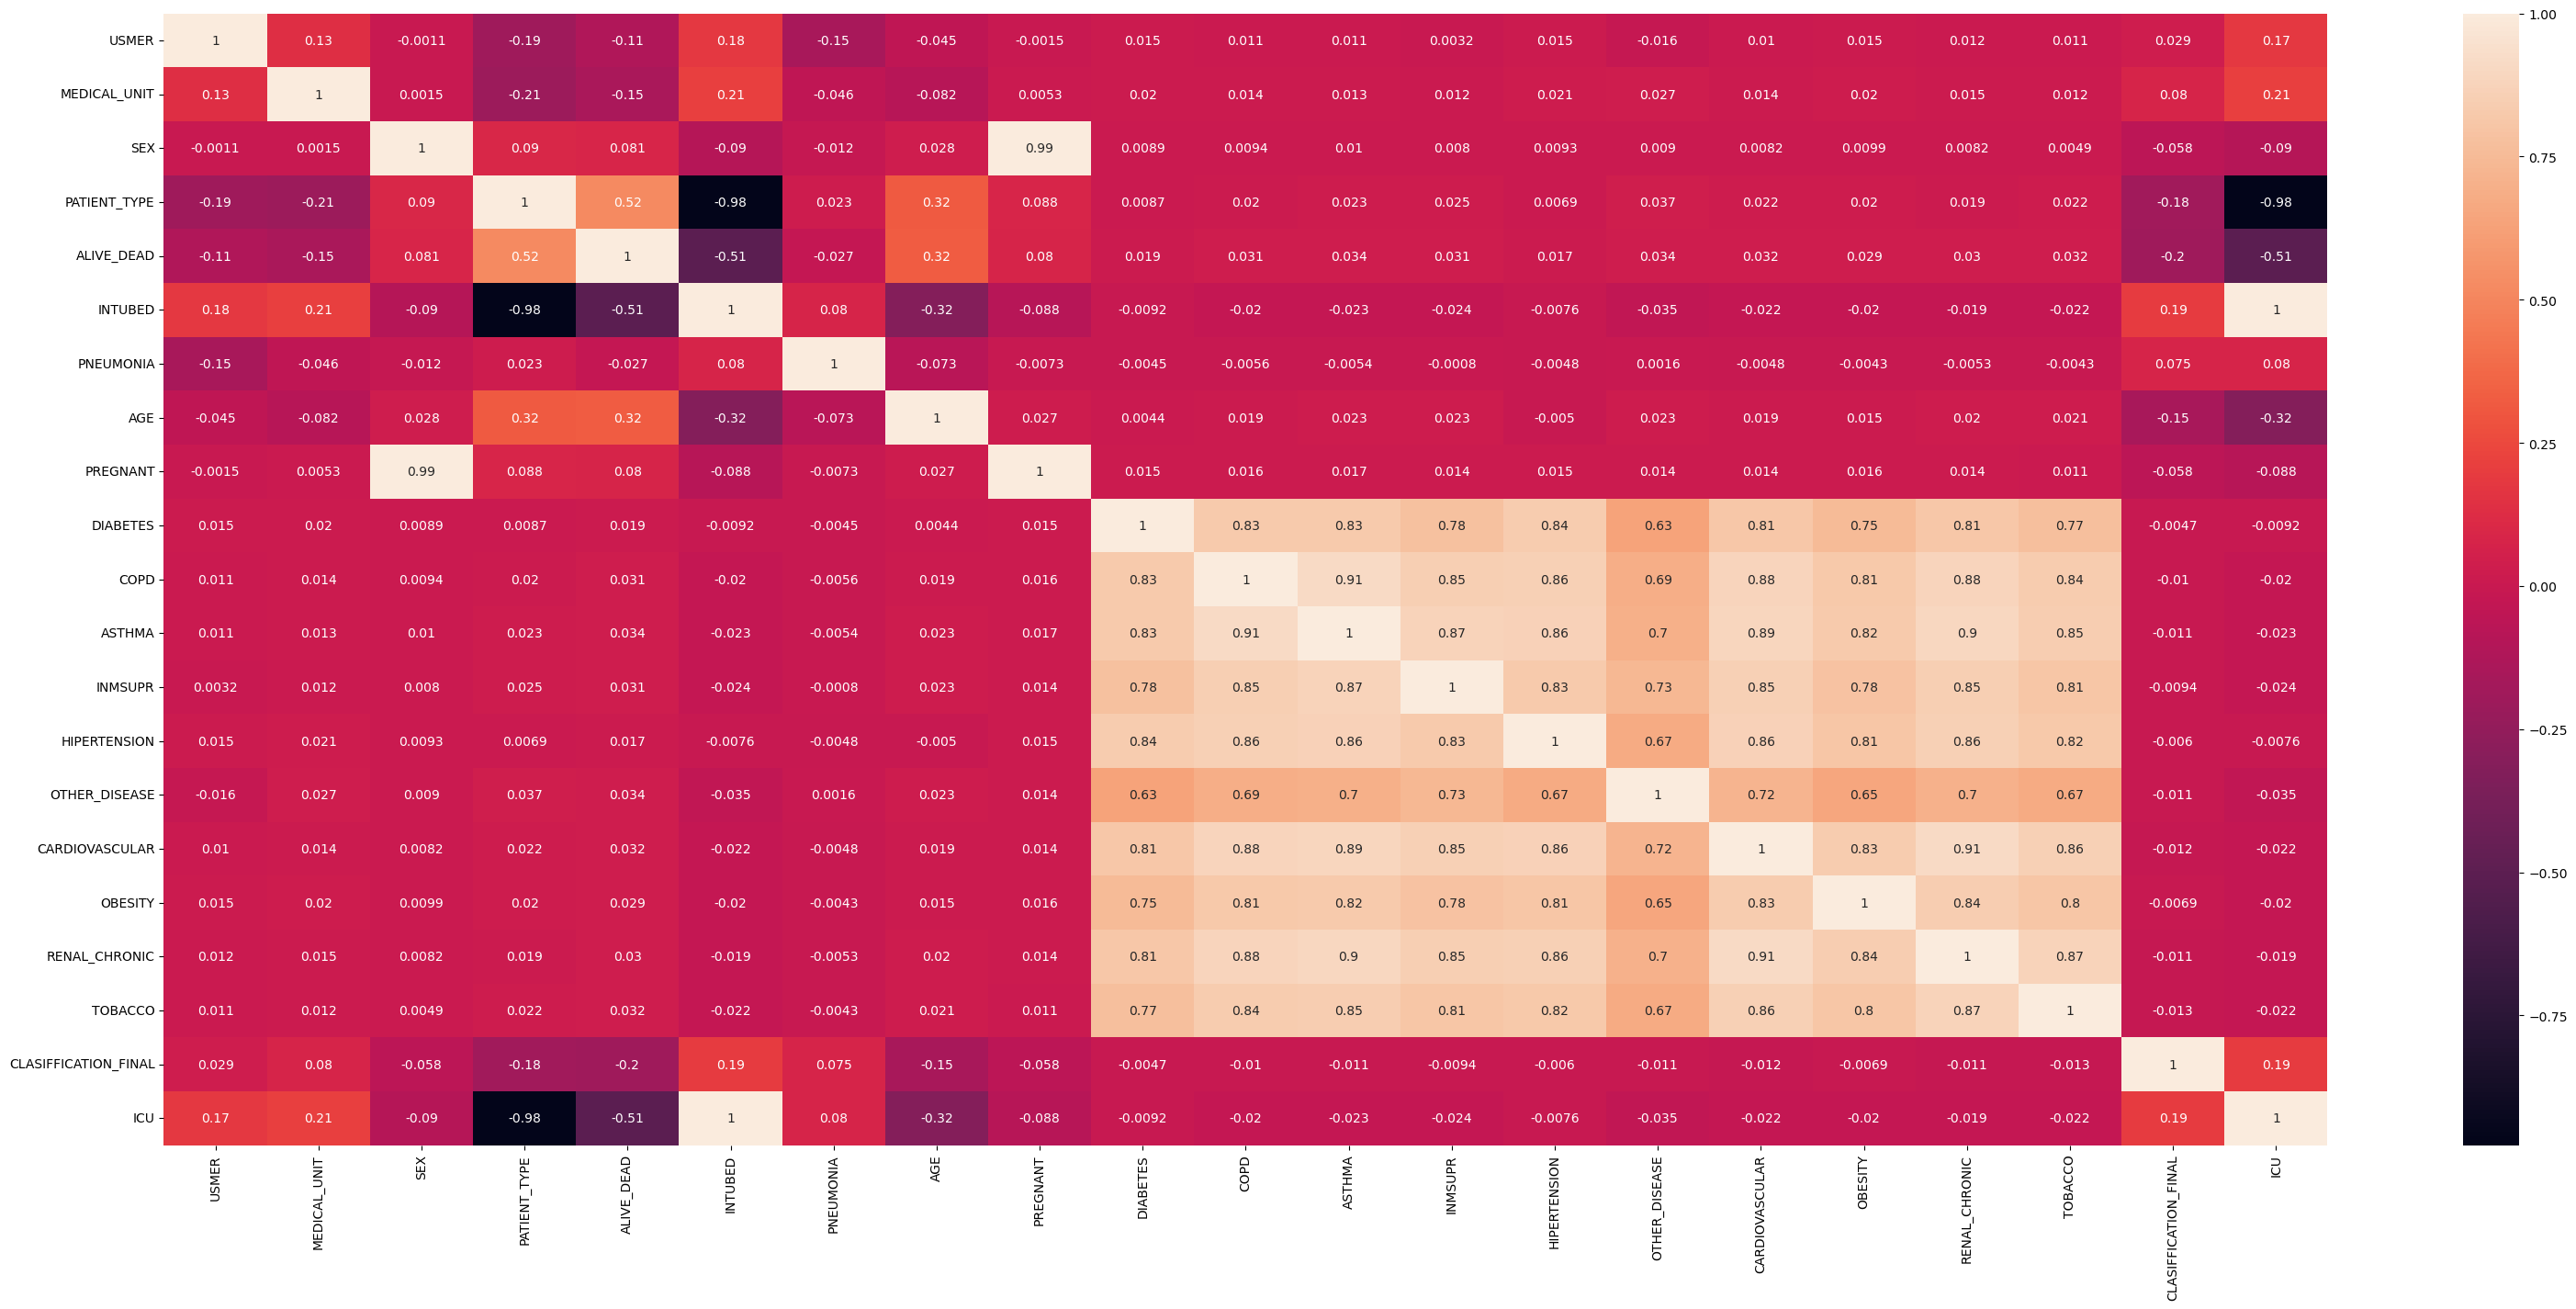

In [22]:
# Heatmap
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Heatmap Analysis

Things that correlated high with ALIVE_DEAD are PATIENT_TYPE, INTUBED, AGE, CLASSIFICATION_FINAL, ICU

### Optimized Logistic Regression

In [23]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')
df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

In [24]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.filter(['PATIENT_TYPE', 'INTUBED', 'AGE', 'CLASSIFICATION_FINAL', 'ICU'], axis=1)
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)
df_x

array([[-0.48552486,  0.47403474,  1.37253057,  0.47377997],
       [-0.48552486,  0.47403474,  1.78655093,  0.47377997],
       [ 2.05962678, -2.12978803,  0.78107292, -2.10612542],
       ...,
       [-0.48552486,  0.47403474,  0.78107292,  0.47377997],
       [-0.48552486,  0.47403474, -0.81586275,  0.47377997],
       [-0.48552486,  0.47403474,  0.60363562,  0.47377997]])

In [25]:
# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 92.93%
The accuracy for the test set is 92.97%


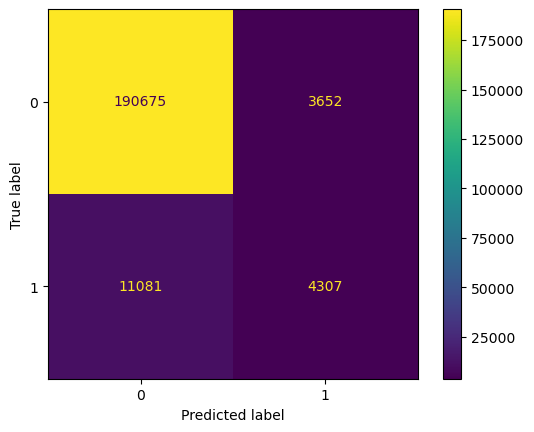

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()